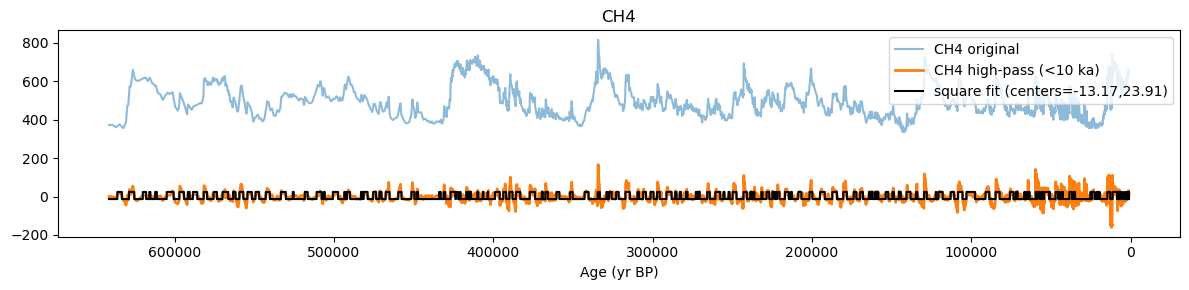

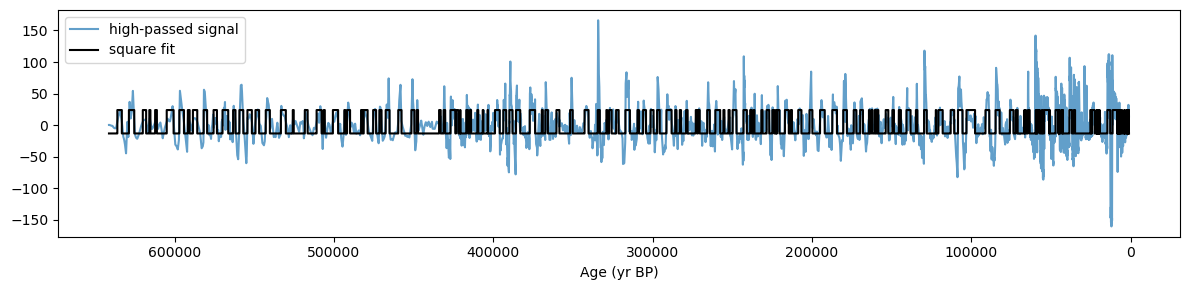

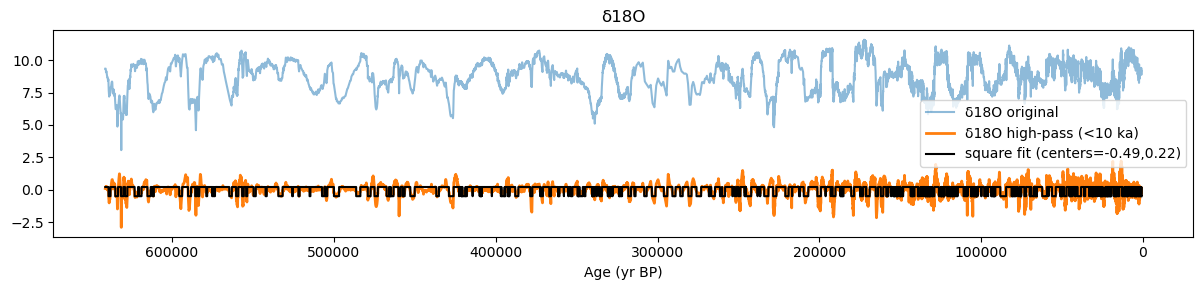

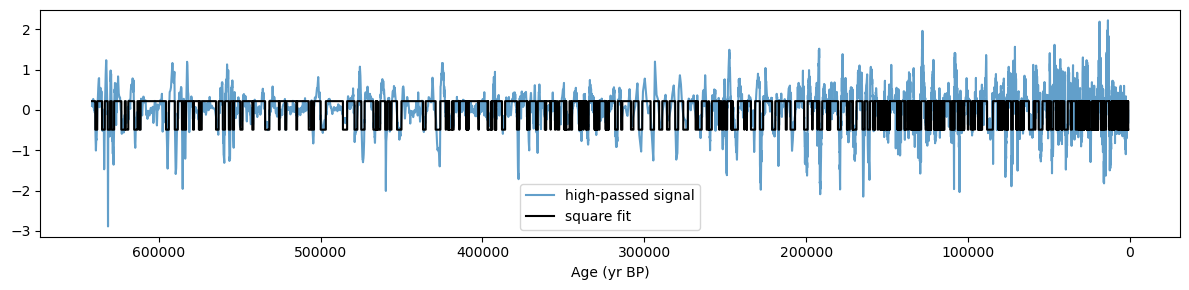

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.cluster import KMeans

# 0) Load raw data
df_ch4 = pd.read_excel('other_data/CH4_AICC2023.xlsx', sheet_name='Sheet1')
file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"
df_d18O = pd.read_excel(file_path)
df_d18O['age'] *= 1000  # to yrs BP
df_d18O['d18O'] = df_d18O['d18O'].values*-1
# renmae column d18O to 'd18O*-1'
df_d18O.rename(columns={'d18O': '-d18O'}, inplace=True)


# 1) Build common 10-yr age grid over their overlap
age_min = 1000 # max(df_ch4['age'].min(), df_d18O['age'].min())
age_max = min(df_ch4['age'].max(), df_d18O['age'].max())
ages = np.arange(age_min, age_max + 1, 20)

# 2) Interpolate each onto that grid
ch4 = np.interp(ages, df_ch4['age'], df_ch4['ch4'])
d18O = np.interp(ages, df_d18O['age'], df_d18O['-d18O'])



ser_ch4  = pd.Series(ch4,  index=ages)
ser_d18O = pd.Series(d18O, index=ages)

# 1) Design a 4th-order Butterworth high-pass filter
fs = 1 / 20.0      # sampling rate: 1 sample per 10 yr → 0.1 yr⁻¹
fc = 1 / 10000.0   # cutoff frequency: want to remove periods > 10 000 yr
Wn = fc / (fs / 2) # normalized cutoff (Nyquist = fs/2)

b, a = butter(N=4, Wn=Wn, btype='highpass')

# 2) Apply filter to each series
#    filtfilt for zero phase‐shift
filt_ch4 = filtfilt(b, a, ser_ch4.values)
filt_d18O = filtfilt(b, a, ser_d18O.values)

# wrap back into Series
resid_ch4 = pd.Series(filt_ch4,  index=ser_ch4.index)
resid_d18O = pd.Series(filt_d18O, index=ser_d18O.index)

def fit_square(resid, min_pts=None):
    """
    1) 2-cluster k-means on the high-passed data
    2) optionally enforce a minimum run length in points
    3) return fitted step wave + cluster centers
    """
    X = resid.values.reshape(-1,1)
    km = KMeans(n_clusters=2, n_init=10, random_state=0).fit(X)
    centers = km.cluster_centers_.flatten()
    labels  = km.labels_
    # ensure centers[0] < centers[1]
    if centers[0] > centers[1]:
        centers = centers[::-1]
        labels  = 1 - labels

    # optional: enforce minimum duration of each phase
    if min_pts is not None:
        def enforce_min(labels, minl):
            lab = labels.copy()
            n = len(lab)
            starts = np.concatenate(([0], np.where(lab[1:]!=lab[:-1])[0]+1))
            ends   = np.concatenate((starts[1:], [n]))
            for s,e in zip(starts, ends):
                if (e-s) < minl:
                    lab[s:e] = 1 - lab[s]
            return lab
        labels = enforce_min(labels, min_pts)

    fit = np.where(labels==1, centers[1], centers[0])
    return fit, centers

# 3) Fit square waves (with e.g. min duration = 30 points if you like)
fit_ch4,  cen_ch4  = fit_square(resid_ch4,  min_pts=30)
fit_d18O, cen_d18O = fit_square(resid_d18O, min_pts=30)

# 4) Plot
for name, orig, filt, fit, cen in [
    ('CH4',  ser_ch4,  resid_ch4,  fit_ch4,  cen_ch4),
    ('δ18O', ser_d18O, resid_d18O, fit_d18O, cen_d18O),
]:
    # original + high-passed + square fit
    plt.figure(figsize=(12,3))
    plt.plot(orig.index, orig,    label=f'{name} original', alpha=0.5)
    plt.plot(filt.index, filt,    label=f'{name} high-pass (<10 ka)', lw=2)
    plt.step(orig.index, fit, where='mid',
             label=f'square fit (centers={cen[0]:.2f},{cen[1]:.2f})',
             color='k')
    plt.gca().invert_xaxis()
    plt.xlabel('Age (yr BP)')
    plt.legend()
    plt.title(name)
    plt.tight_layout()
    plt.show()

    # high-passed + square fit only
    plt.figure(figsize=(12,3))
    plt.plot(filt.index, filt,    label='high-passed signal', alpha=0.7)
    plt.step(filt.index, fit, where='mid', label='square fit', color='k')
    plt.gca().invert_xaxis()
    plt.xlabel('Age (yr BP)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# df_filt_ch4 = pd.DataFrame({'age':filt.index, 'fit_ch4':fit_ch4})
# df_filt_d18O = pd.DataFrame({'age':filt.index, 'fit_d18O':fit_d18O})

df_filt_ch4 = pd.DataFrame({'age':filt.index, 'filt_ch4':filt_ch4})
df_filt_d18O = pd.DataFrame({'age':filt.index, 'filt_d18O':filt_d18O})


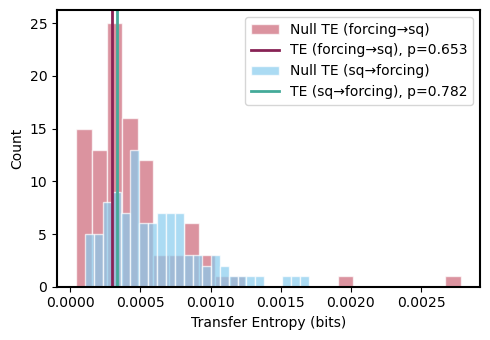

False


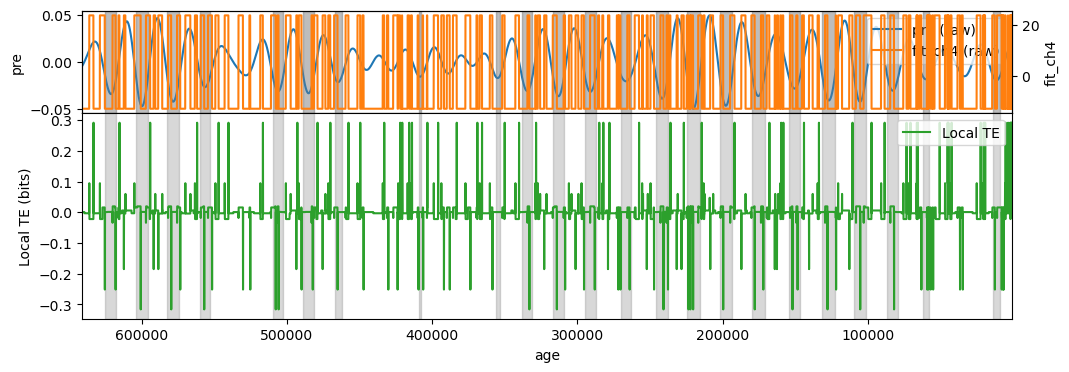

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 100, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['fit_ch4'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=3, sq_bins=4)
print(result)


# df_sq_i['filt_ch4']=df_sq_i['filt_ch4']*-1
LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='fit_ch4',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

In [48]:
print(df_filt_ch4.info) 
print(df_filt_d18O.info)

<bound method DataFrame.info of             age   filt_ch4
0        1000.0  13.987609
1        1020.0  20.293962
2        1040.0  15.600321
3        1060.0  18.688657
4        1080.0  21.430708
...         ...        ...
32009  641180.0   0.375254
32010  641200.0   0.369698
32011  641220.0   0.362769
32012  641240.0   0.354431
32013  641260.0   0.344651

[32014 rows x 2 columns]>
<bound method DataFrame.info of             age  filt_d18O
0        1000.0  -0.020968
1        1020.0  -0.125719
2        1040.0  -0.333642
3        1060.0  -0.201505
4        1080.0  -0.067365
...         ...        ...
32009  641180.0   0.150517
32010  641200.0   0.139649
32011  641220.0   0.128739
32012  641240.0   0.117787
32013  641260.0   0.106792

[32014 rows x 2 columns]>


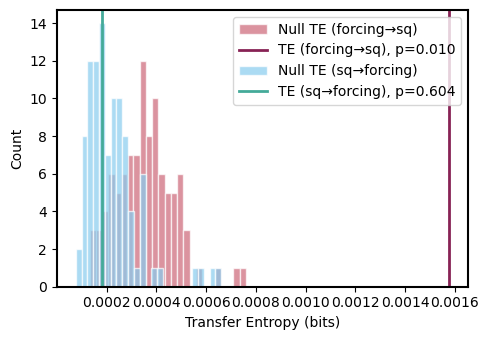

True


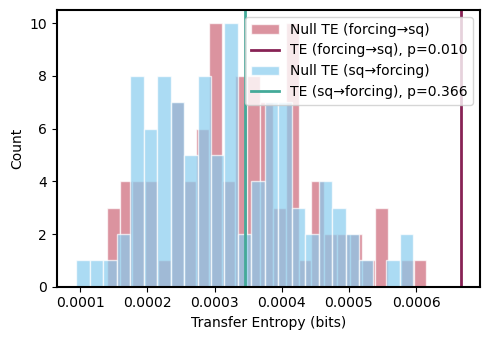

True


In [76]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 20, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_ch4'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=3, sq_bins=4)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6)
print(result)


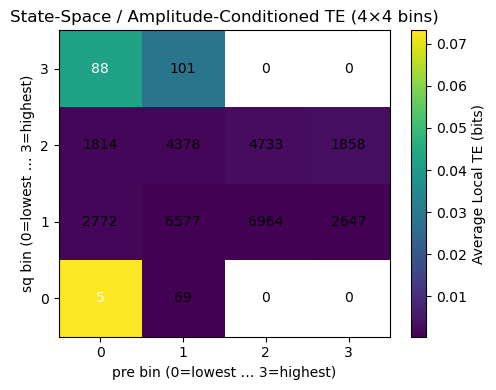

x_idx_clipped: [2 2 2 ... 1 1 1]
Mask: [False False False ... False False False]
Counts: [4 1]
Cell (pre=low, sq=low): 5 samples
   P(sq_next=0 | 0,0) = 0.800
   P(sq_next=1 | 0,0) = 0.200
Mask: [False False False ... False False False]
Counts: [ 0  0  5 83  1]

Cell (pre=high, sq=low): 89 samples
   P(sq_next=0 | 3,0) = 0.000
   P(sq_next=1 | 3,0) = 0.000


In [98]:
import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy

# reverse series if needed
sq  = sq[::-1]
pre = pre[::-1]

# Bin definitions
nbins_pre = 4
nbins_sq  = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
bins_sq   = np.histogram_bin_edges(sq,  bins=nbins_sq)

pre_disc = np.digitize(pre, bins_pre) - 1   # 0..3
sq_disc  = np.digitize(sq,  bins_sq)  - 1

# Compute local TE
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)
te       = local_te.flatten()[1:]           # drop the very first
x_idx    = pre_disc[1:-1]
y_idx    = sq_disc[1:-1]

# Build heatmap of mean TE per bin
heatmap = np.full((nbins_pre, nbins_sq), np.nan)
counts  = np.zeros((nbins_pre, nbins_sq), int)

for i in range(nbins_pre):
    for j in range(nbins_sq):
        mask = (x_idx == i) & (y_idx == j)
        counts[i, j] = mask.sum()
        if counts[i, j] > 0:
            heatmap[i, j] = te[mask].mean()

# Plot
plt.figure(figsize=(5,4))
# note: extent uses [xmin, xmax, ymin, ymax] = [0,4,0,4]
plt.imshow(heatmap.T, origin='lower', aspect='auto',
           extent=[0, nbins_pre, 0, nbins_sq])
plt.colorbar(label='Average Local TE (bits)')

# annotate counts
for i in range(nbins_pre):
    for j in range(nbins_sq):
        # center of cell is at (i+0.5, j+0.5)
        plt.text(i + 0.5, j + 0.5,
                 str(counts[i, j]),
                 ha='center', va='center',
                 color='white' if not np.isnan(heatmap[i, j]) and heatmap[i,j] > (np.nanmax(heatmap)/2) else 'black')

plt.xlabel('pre bin (0=lowest … 3=highest)')
plt.ylabel('sq bin (0=lowest … 3=highest)')
plt.title('State‐Space / Amplitude‐Conditioned TE (4×4 bins)')

plt.xticks(np.arange(0.5, nbins_pre+0.5), np.arange(nbins_pre))
plt.yticks(np.arange(0.5, nbins_sq+0.5), np.arange(nbins_sq))

plt.tight_layout()
plt.show()




# Clip indices just in case
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
print(f"x_idx_clipped: {x_idx_clipped}")
y_idx_clipped = np.clip(y_idx, 0, nbins_sq-1)
z_idx = sq_disc[2:]

# Function to compute P(z | x=i, y=j)
def transition_probs(i, j):
    mask = (x_idx_clipped == i) & (y_idx_clipped == j)
    print(f"Mask: {mask}")
    counts = np.bincount(z_idx[mask], minlength=2)
    print(f"Counts: {counts}")
    total = counts.sum()
    return counts / total, total

# Get for the “low-pre & low-sq” cell (i=0, j=0)
probs_00, total_00 = transition_probs(0, 0)
print(f"Cell (pre=low, sq=low): {total_00} samples")
print(f"   P(sq_next=0 | 0,0) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,0) = {probs_00[1]:.3f}")

# And for comparison, say “pre=low, sq=hih (i=3, j=0)
probs_30, total_30 = transition_probs(0, 3)
print(f"\nCell (pre=high, sq=low): {total_30} samples")
print(f"   P(sq_next=0 | 3,0) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,0) = {probs_30[1]:.3f}")


In [81]:
x_idx.shape

(32013,)

In [82]:
te.shape

(32012,)

In [83]:
y_idx.shape

(32013,)

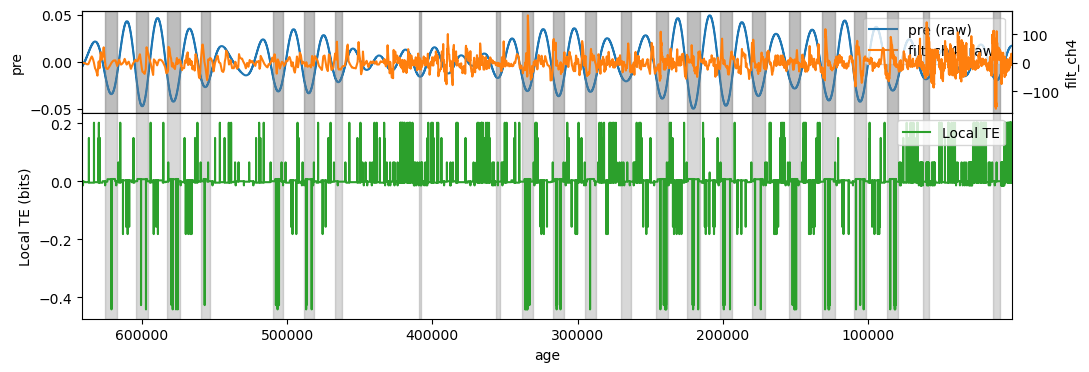

In [58]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

# smooth the filt_ch4 with a window of 100 pt
# df_sq_i['filt_ch4'] = df_sq_i['filt_ch4'].rolling(window=100).mean()

# df_sq_i['filt_ch4']=df_sq_i['filt_ch4']*-1
LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=4)

In [61]:
# check if there is nan in df_sq_i
print(df_sq_i.isna().sum())
# chec k if there is nan in df_pre_i
print(df_pre_i.isna().sum())


age         0
filt_ch4    0
dtype: int64
age    0
pre    0
dtype: int64


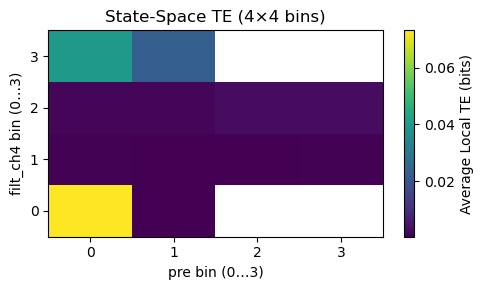

Joint counts (rows=pre_bin, cols=sq_bin):
[[   5 2772 1814   89]
 [  69 6578 4378  101]
 [   0 6964 4733    0]
 [   0 2647 1863    0]]

Marginal counts for pre_bins:
  pre_bin 0: 4680
  pre_bin 1: 11126
  pre_bin 2: 11697
  pre_bin 3: 4510

Marginal counts for sq_bins:
  sq low (0): 74
  sq high (1): 18961
  sq high (2): 12788
  sq high (3): 190

Cell (pre=low, sq=low): 5 samples
  P(sq_next=0)=0.800, P(sq_next=1)=0.200

Cell (pre=high, sq=low): 0 samples
  P(sq_next=0)=0.000, P(sq_next=1)=0.000


In [66]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

results = sa.analyze_state_space_TE(
    df_pre_i,
    df_sq_i,
    forcing_column='pre',
    target_column='filt_ch4',
    nbins_pre=4,
    nbins_sq=4
)

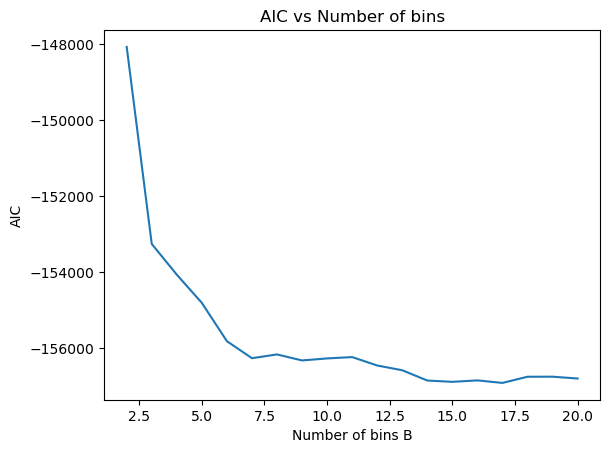

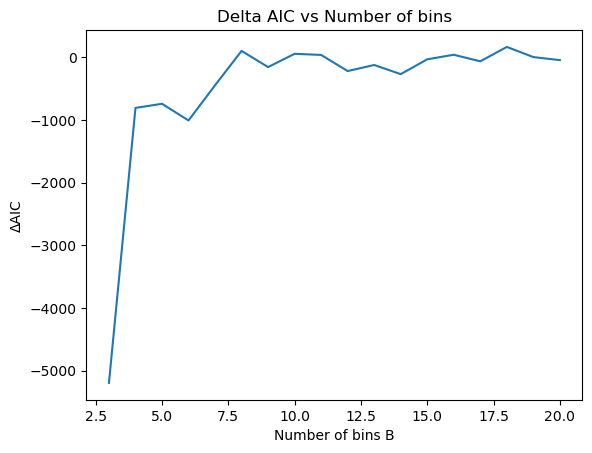

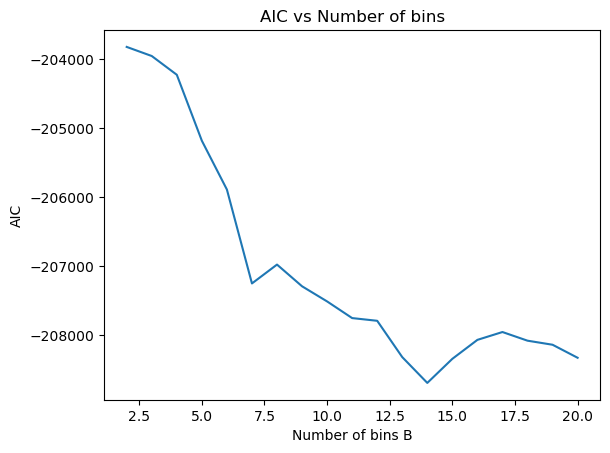

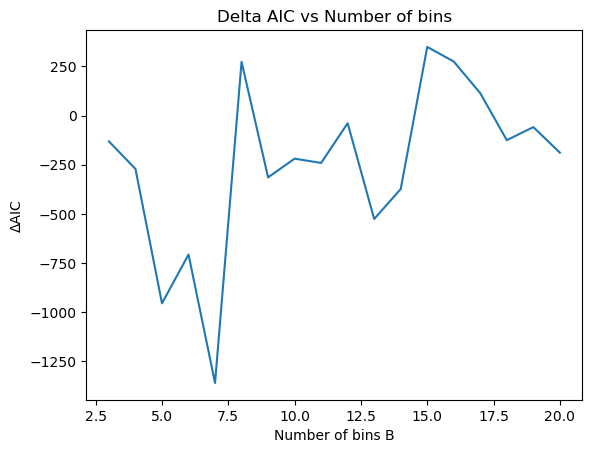

In [45]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

sa.plot_aic_delta(df_pre_i['pre'].values)
sa.plot_aic_delta(df_obl_i['obl'].values)

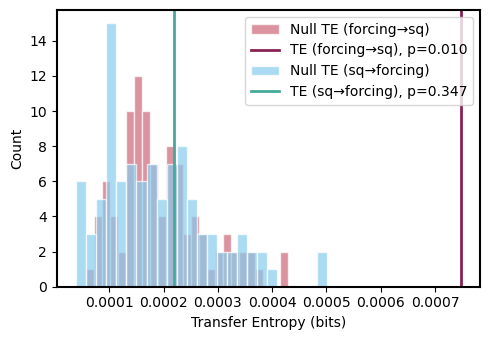

True


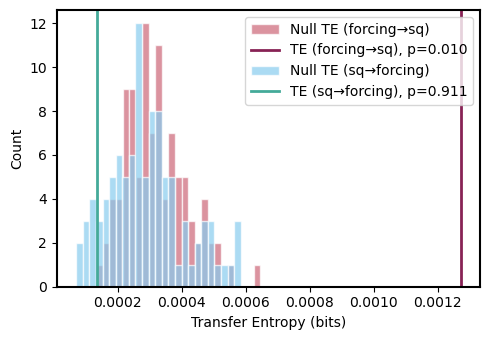

True


In [4]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_d18O.copy(), 20, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['filt_d18O'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=4)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6)
print(result)

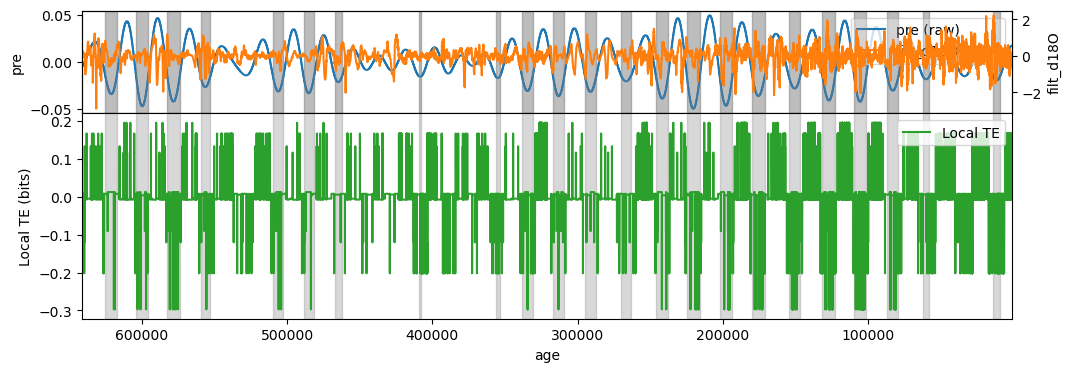

In [5]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

LTE = sa.local_TE(df_pre_i, df_sq_i,
                   forcing_column='pre',
                   target_column='filt_d18O',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

641264.4
-16.501


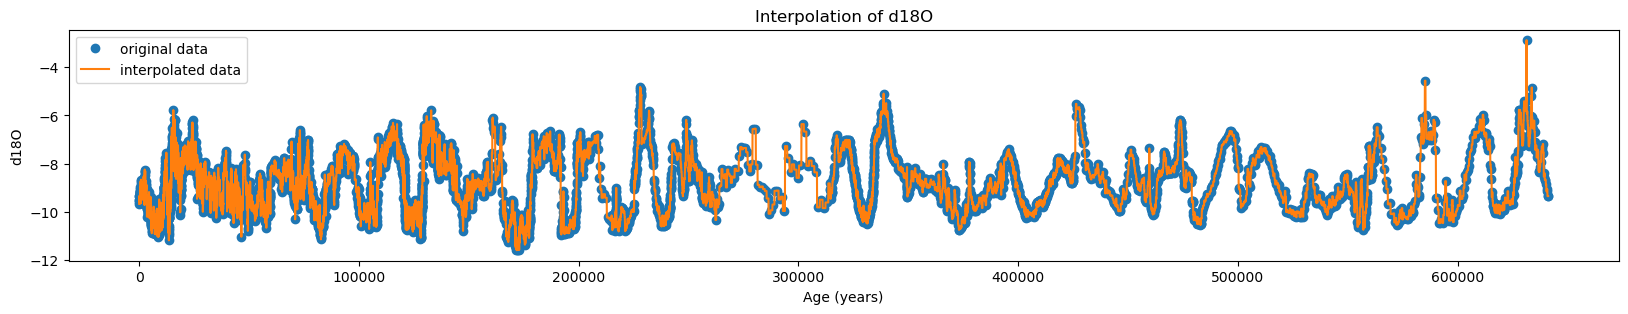

In [1]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"
df = pd.read_excel(file_path)
df['age'] = df['age'] * 1000
print(np.max(df['age']))
print(np.min(df['age']))

col = df.columns[1] 

df = df[['age', col]].sort_values('age').reset_index(drop=True)



new_age = np.arange(0, 641260, 20)



f_interp = interp1d(df['age'], df[col],
                    kind='nearest',
                    bounds_error=False,
                    fill_value=1)
new_df = pd.DataFrame({'age': new_age,
                        col: f_interp(new_age)})

# plot df and new_df
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(df['age'], df[col], 'o', label='original data')
plt.plot(new_df['age'], new_df[col], '-', label='interpolated data')
plt.xlabel('Age (years)')
plt.ylabel(col)
plt.title('Interpolation of ' + col)
plt.legend()
plt.show()

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt

def remove_orbital_component(df, col_name='d18O', cutoff=1/20000, order=4):
    """
    High-pass filter the specified column of a DataFrame to remove frequencies 
    below `cutoff` (yr⁻¹) and return a new DataFrame with 'age' and '{col_name}_hp'.

    Parameters
    ----------
    df : pandas.DataFrame
        Must have columns 'age' (evenly spaced in years) and `col_name`.
    col_name : str
        Name of the column to filter (default 'd18O').
    cutoff : float
        Cutoff frequency in yr⁻¹ (default 1/20000).
    order : int
        Order of the Butterworth filter (default 4).

    Returns
    -------
    pandas.DataFrame
        Two columns:
        - 'age' : same as input
        - '{col_name}_hp' : the high-pass filtered series
    """
    if 'age' not in df.columns or col_name not in df.columns:
        raise ValueError(f"DataFrame must contain 'age' and '{col_name}' columns.")

    age = df['age'].to_numpy()
    signal = df[col_name].to_numpy()

    # Ensure uniform sampling
    dt = np.diff(age)
    if not np.allclose(dt, dt[0]):
        raise ValueError("Age steps must be uniform to define a constant sampling rate.")
    fs = 1.0 / dt[0]         # samples per year
    nyq = fs / 2.0           # Nyquist frequency
    wn = cutoff / nyq        # normalized cutoff

    if wn <= 0 or wn >= 1:
        raise ValueError(f"Normalized cutoff wn={wn:.3e} invalid; check your cutoff and sampling rate.")

    # Design & apply zero-phase high-pass Butterworth
    b, a = butter(order, wn, btype='high', analog=False)
    filtered = filtfilt(b, a, signal)

    # Build output DataFrame with dynamic column name
    return pd.DataFrame({
        'age': age,
        f'{col_name}_hp': filtered
    })


import numpy as np
import pandas as pd

def threshold_to_noise(df, 
                       col='d18O', 
                       lower_pct=5, 
                       upper_pct=95, 
                       noise_mean=0,
                       sigma=0.5):
    """
    Replace values of df[col] below the lower_pct‐percentile or 
    above the upper_pct‐percentile with white noise.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame with at least the column `col`.
    col : str
        Name of the column to threshold.
    lower_pct : float
        Lower percentile cutoff (0–100).
    upper_pct : float
        Upper percentile cutoff (0–100).
    noise_mean : float
        Mean of the white‐noise distribution (default = 0).
    
    Returns
    -------
    df_out : pandas.DataFrame
        A copy of df where outliers in `col` are replaced by noise.
    lower_bound, upper_bound : float, float
        The thresholds actually used.
    """
    df_out = df.copy()
    series = df_out[col]
    
    # compute percentile thresholds
    lower_bound = np.percentile(series, lower_pct)
    upper_bound = np.percentile(series, upper_pct)
    
    # compute noise parameters
    # sigma = series.std()
    
    # mask of outliers
    mask = (series < lower_bound) | (series > upper_bound)
    n_outliers = mask.sum()
    
    # generate white noise for those positions
    noise = np.random.normal(loc=noise_mean, scale=sigma, size=n_outliers)
    
    # replace
    df_out.loc[mask, col] = noise
    
    print(f"Replaced {n_outliers} values <{lower_bound:.3f} or >{upper_bound:.3f} with N({noise_mean},{sigma:.3f}²) noise")
    return df_out, lower_bound, upper_bound


import numpy as np
import pandas as pd
from scipy.signal import find_peaks, lombscargle
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def plot_envelopes_and_psd(df):
    """
    For a DataFrame with two columns (age and signal), this function:
      1. Calculates upper and lower envelopes via peak/trough interpolation.
      2. Plots the original signal with its envelopes.
      3. Computes the Lomb-Scargle periodogram of both envelopes.
      4. Plots the PSD (log-log) of upper and lower envelopes.
    """
    # extract age and signal
    age = df.iloc[:, 0].values
    signal = df.iloc[:, 1].values

    # find local maxima (peaks) and minima (troughs)
    peaks, _ = find_peaks(signal)
    troughs, _ = find_peaks(-signal)

    # interpolate to get continuous envelopes
    up_env = interp1d(age[peaks], signal[peaks], kind='cubic',
                      bounds_error=False, fill_value='extrapolate')(age)
    lo_env = interp1d(age[troughs], signal[troughs], kind='cubic',
                      bounds_error=False, fill_value='extrapolate')(age)

    # 1) Plot original signal with envelopes
    plt.figure()
    plt.plot(age, signal, label='Original')
    plt.plot(age, up_env, label='Upper envelope')
    plt.plot(age, lo_env, label='Lower envelope')
    plt.xlabel('Age (yr)')
    plt.ylabel('Signal')
    plt.legend()
    plt.title('Signal with Upper and Lower Envelopes')
    plt.show()

    # 2) Compute Lomb-Scargle PSD for envelopes
    # define frequency array: from low freq ~1e-4 to Nyquist = 1/(2*dt)
    dt = np.mean(np.diff(age))
    nyquist = 1/(2*dt)
    freqs = np.linspace(1e-4, nyquist, 1000)
    ang_freqs = 2 * np.pi * freqs

    p_up = lombscargle(age, up_env, ang_freqs)
    p_lo = lombscargle(age, lo_env, ang_freqs)

    # 3) Plot PSD on log-log scale
    plt.figure()
    plt.loglog(freqs, p_up, label='Upper envelope PSD')
    plt.loglog(freqs, p_lo, label='Lower envelope PSD')
    plt.xlabel('Frequency (1/yr)')
    plt.ylabel('Lomb-Scargle Power')
    plt.legend()
    plt.title('Lomb-Scargle PSD of Envelopes')
    plt.show()




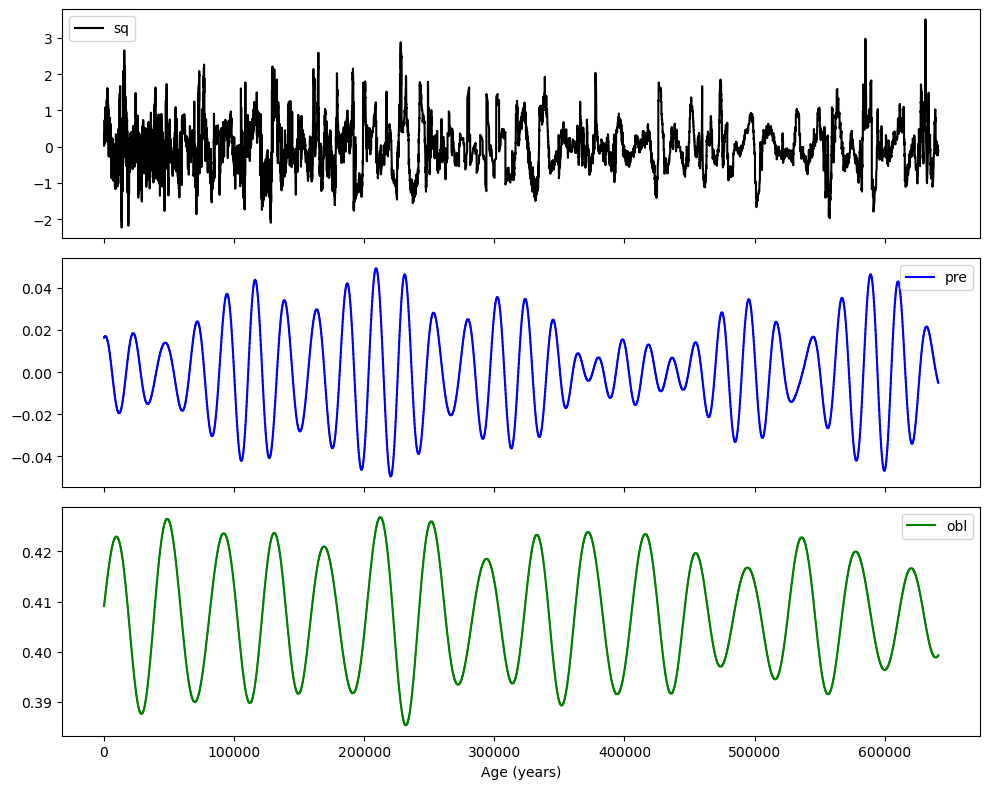

          age   d18O_hp
0           0  0.027887
1          20  0.109018
2          40  0.190153
3          60  0.361292
4          80  0.362436
...       ...       ...
32058  641160 -0.133319
32059  641180 -0.126093
32060  641200 -0.118917
32061  641220 -0.111791
32062  641240 -0.104716

[32063 rows x 2 columns]
          age       pre
0           0  0.016280
1          20  0.016280
2          40  0.016280
3          60  0.016431
4          80  0.016431
...       ...       ...
32058  641160 -0.005173
32059  641180 -0.005173
32060  641200 -0.005173
32061  641220 -0.005173
32062  641240 -0.005173

[32063 rows x 2 columns]
Length of df_sq_rs: 32063


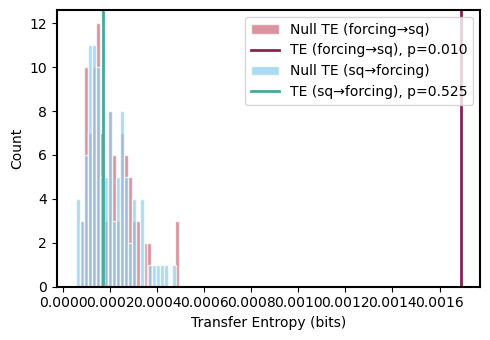

(True, <Figure size 500x350 with 1 Axes>)

In [3]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_hp = remove_orbital_component(new_df, col_name='d18O')

df_sq, df_pre, df_obl = sa.interpolate_data_forcing(df_hp, 20, if_plot=True)
print(df_sq)
print(df_pre)
# print the length of df_sq_rs and df_pre_rs
print('Length of df_sq_rs:', len(df_sq))


from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


pre = df_pre['pre'].values      # source (precession)
sq = df_sq['d18O_hp'].values    # target (residual)


result =sa.transfer_entropy_surrogate_test(pre,sq,forcing_bins=4)
result

Replaced 12826 values <-0.848 or >0.869 with N(0,0.100²) noise


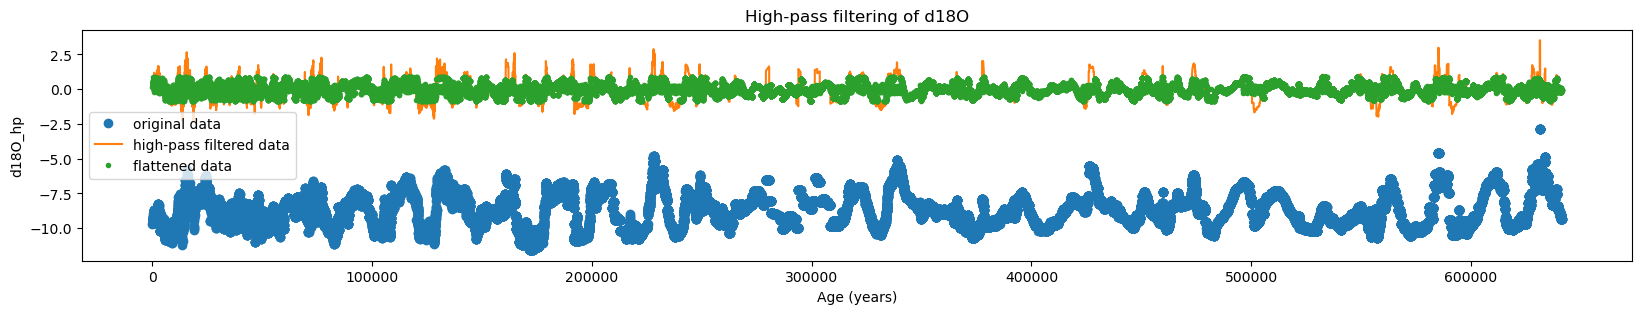

In [24]:

df_hp = remove_orbital_component(new_df, col_name='d18O')
df_flattened, _, _ = threshold_to_noise(df_hp, col=col + '_hp', lower_pct=10, upper_pct=90, noise_mean=0, sigma=0.1)
# plot new_df and df_hp
plt.figure(figsize=(20, 3))
plt.plot(new_df['age'], new_df[col], 'o', label='original data')
plt.plot(df_hp['age'], df_hp[col + '_hp'], '-', label='high-pass filtered data')
plt.plot(df_flattened['age'], df_flattened[col + '_hp'], '.', label='flattened data')
plt.xlabel('Age (years)')
plt.ylabel(col + '_hp')
plt.title('High-pass filtering of ' + col)
plt.legend()
plt.show()

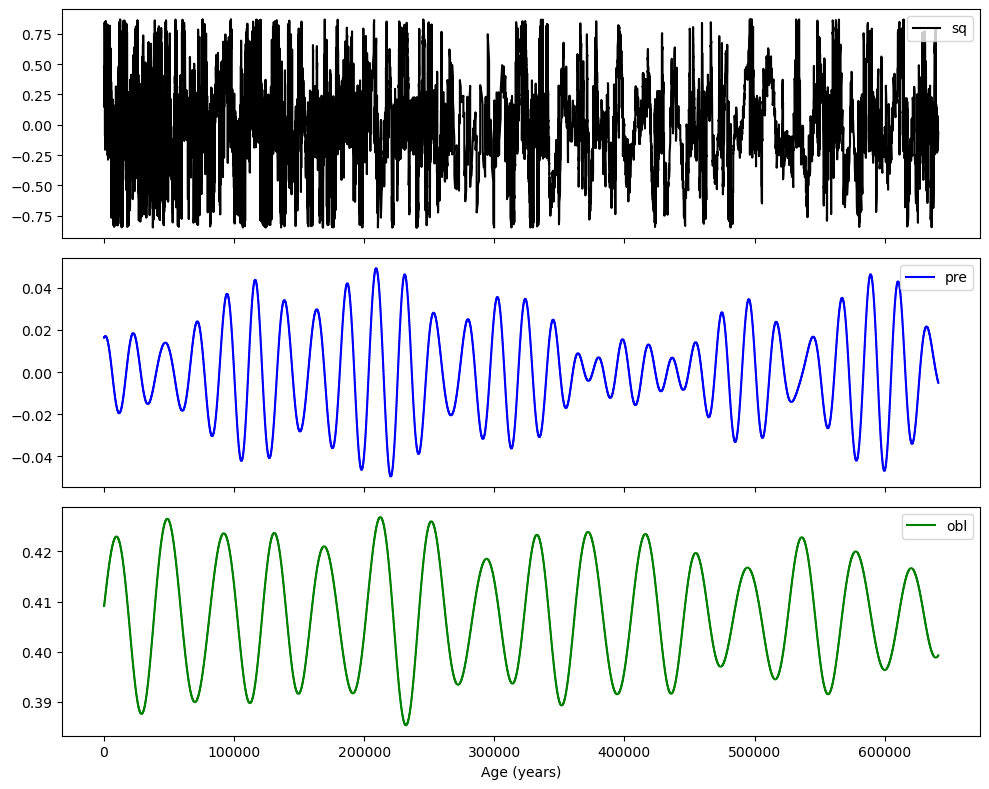

          age   d18O_hp
0           0  0.150830
1          10  0.231124
2          20  0.231418
3          30  0.311714
4          40  0.312011
...       ...       ...
64121  641210 -0.077534
64122  641220 -0.073614
64123  641230 -0.069705
64124  641240 -0.065807
64125  641250 -0.061921

[64126 rows x 2 columns]
          age       pre
0           0  0.016280
1          10  0.016280
2          20  0.016280
3          30  0.016280
4          40  0.016280
...       ...       ...
64121  641210 -0.005173
64122  641220 -0.005173
64123  641230 -0.005173
64124  641240 -0.005173
64125  641250 -0.005173

[64126 rows x 2 columns]
Length of df_sq_rs: 64126


In [25]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq, df_pre, df_obl = sa.interpolate_data_forcing(df_flattened, 10, if_plot=True)
print(df_sq)
print(df_pre)
# print the length of df_sq_rs and df_pre_rs
print('Length of df_sq_rs:', len(df_sq))

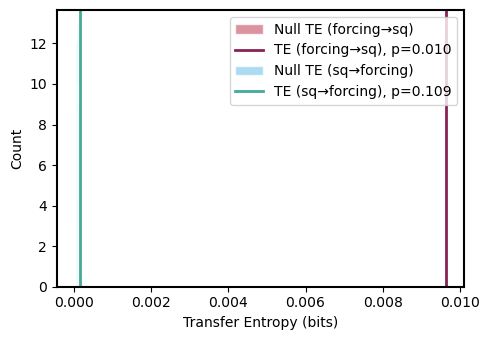

(True, <Figure size 500x350 with 1 Axes>)

In [26]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


pre = df_pre['pre'].values      # source (precession)
sq = df_sq['d18O_hp'].values    # target (residual)


result =sa.transfer_entropy_surrogate_test(pre,sq,forcing_bins=4)
result